# Background removal with RMBG v1.4 and OpenVINO

Background matting is the process of accurately estimating the foreground object in images and videos. It is a very important technique in image and video editing applications, particularly in film production for creating visual effects. In case of image segmentation, we segment the image into foreground and background by labeling the pixels. Image segmentation generates a binary image, in which a pixel either belongs to foreground or background. However, Image Matting is different from the image segmentation, wherein some pixels may belong to foreground as well as background, such pixels are called partial or mixed pixels. In order to fully separate the foreground from the background in an image, accurate estimation of the alpha values for partial or mixed pixels is necessary.

RMBG v1.4 is background removal model, designed to effectively separate foreground from background in a range of categories and image types. This model has been trained on a carefully selected dataset, which includes: general stock images, e-commerce, gaming, and advertising content, making it suitable for commercial use cases powering enterprise content creation at scale. The accuracy, efficiency, and versatility currently rival leading source-available models.

More details about model can be found in [model card](https://huggingface.co/briaai/RMBG-1.4).

In this tutorial we consider how to convert and run this model using OpenVINO.
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load PyTorch model](#Load-PyTorch-model)
- [Run PyTorch model inference](#Run-PyTorch-model-inference)
- [Convert Model to OpenVINO Intermediate Representation format](#Convert-Model-to-OpenVINO-Intermediate-Representation-format)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/rmbg-background-removal/rmbg-background-removal.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

install required dependencies

In [ ]:
%pip install -q torch torchvision pillow huggingface_hub "openvino>=2024.0.0" matplotlib "gradio>=4.15" "transformers>=4.39.1" tqdm --extra-index-url https://download.pytorch.org/whl/cpu

Download model code from HuggingFace hub

In [2]:
from huggingface_hub import hf_hub_download
from pathlib import Path

repo_id = "briaai/RMBG-1.4"

download_files = ["utilities.py", "example_input.jpg"]

for file_for_downloading in download_files:
    if not Path(file_for_downloading).exists():
        hf_hub_download(repo_id=repo_id, filename=file_for_downloading, local_dir=".")

## Load PyTorch model
[back to top ⬆️](#Table-of-contents:)

For loading model using PyTorch, we should use `AutoModelForImageSegmentation.from_pretrained` method. Model weights will be downloaded automatically during first model usage. Please, note, it may take some time.

In [ ]:
from transformers import AutoModelForImageSegmentation

net = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4", trust_remote_code=True)

## Run PyTorch model inference
[back to top ⬆️](#Table-of-contents:)

`preprocess_image` function is responsible for preparing input data in model-specific format. `postprocess_image` function is responsible for postprocessing model output. After postprocessing, generated background mask can be inserted into original image as alpha-channel.

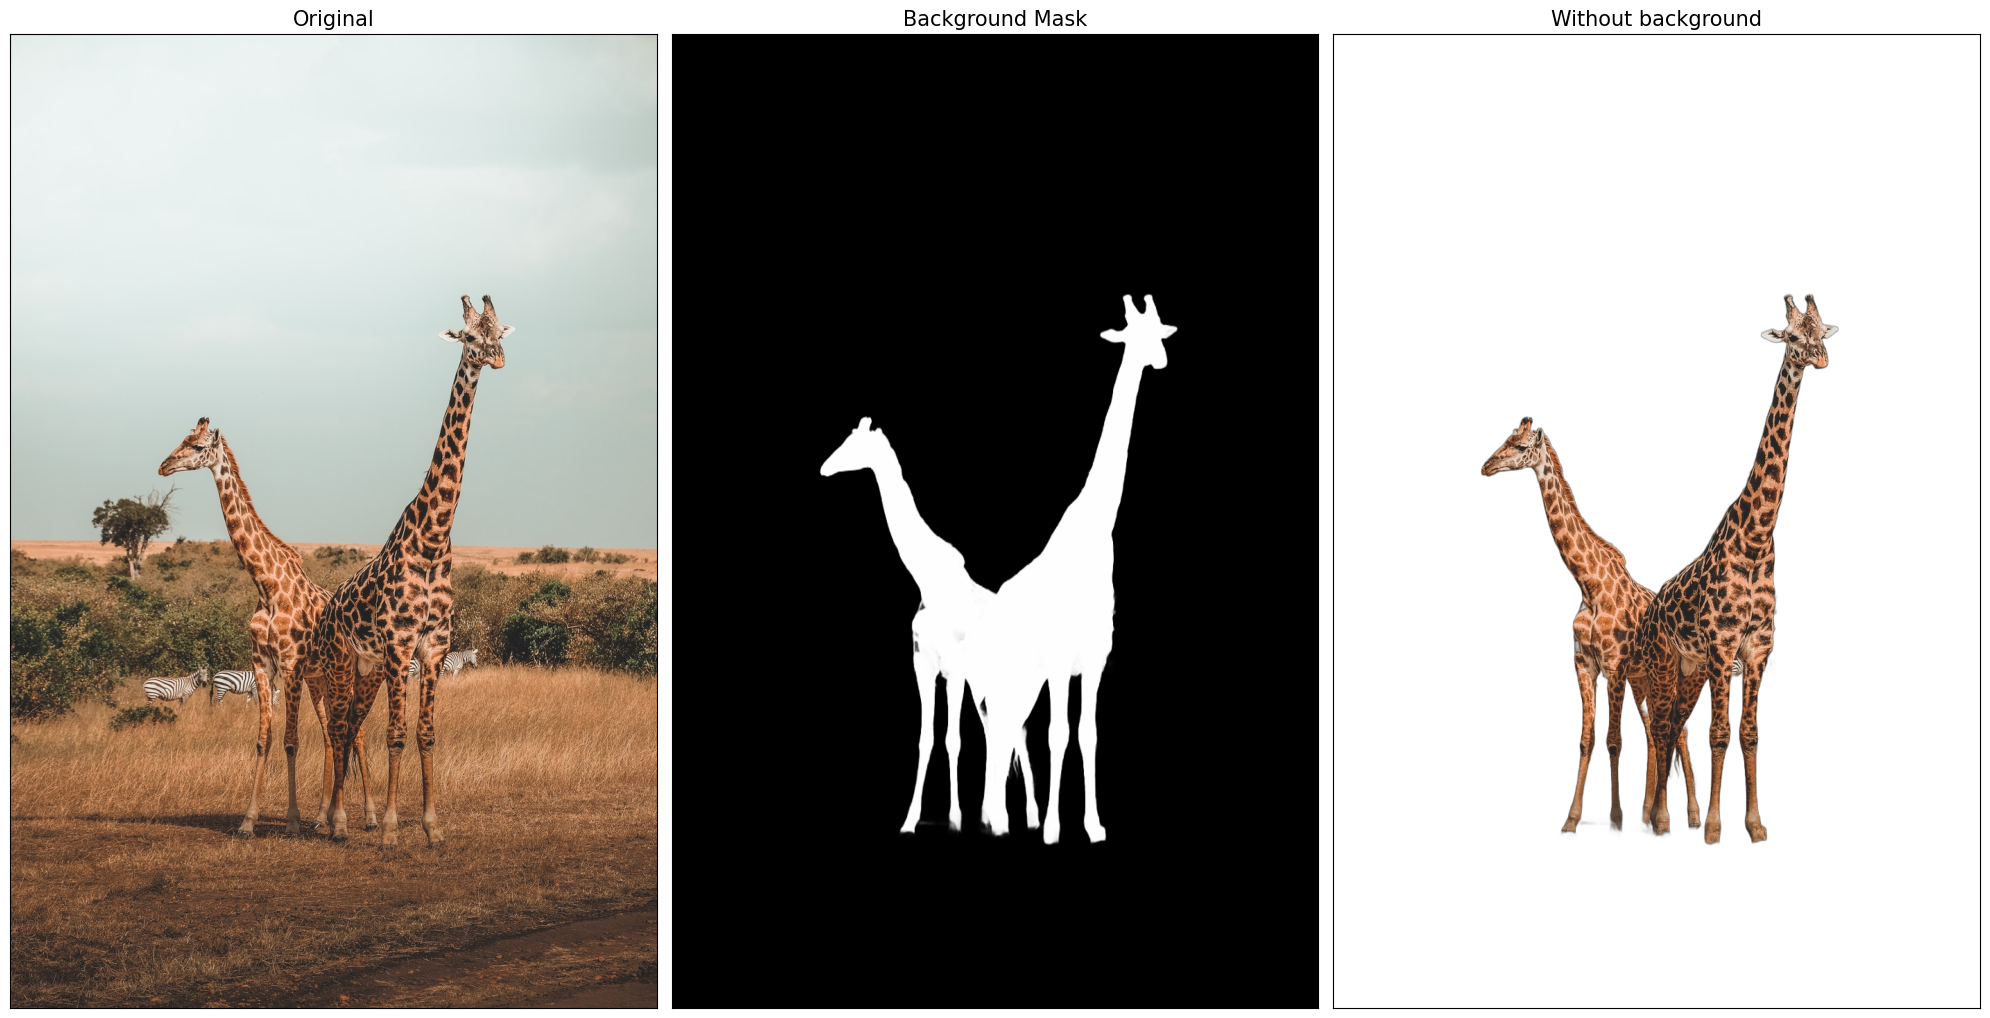

In [4]:
import torch
from PIL import Image
from utilities import preprocess_image, postprocess_image
import numpy as np
from matplotlib import pyplot as plt


def visualize_result(orig_img: Image, mask: Image, result_img: Image):
    """
    Helper for results visualization

    parameters:
       orig_img (Image): input image
       mask (Image): background mask
       result_img (Image) output image
    returns:
      plt.Figure: plot with 3 images for visualization
    """
    titles = ["Original", "Background Mask", "Without background"]
    im_w, im_h = orig_img.size
    is_horizontal = im_h <= im_w
    figsize = (20, 20)
    num_images = 3
    fig, axs = plt.subplots(
        num_images if is_horizontal else 1,
        1 if is_horizontal else num_images,
        figsize=figsize,
        sharex="all",
        sharey="all",
    )
    fig.patch.set_facecolor("white")
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(mask), cmap="gray")
    list_axes[0].set_title(titles[0], fontsize=15)
    list_axes[1].set_title(titles[1], fontsize=15)
    list_axes[2].imshow(np.array(result_img))
    list_axes[2].set_title(titles[2], fontsize=15)

    fig.subplots_adjust(wspace=0.01 if is_horizontal else 0.00, hspace=0.01 if is_horizontal else 0.1)
    fig.tight_layout()
    return fig


im_path = "./example_input.jpg"

# prepare input
model_input_size = [1024, 1024]
orig_im = np.array(Image.open(im_path))
orig_im_size = orig_im.shape[0:2]
image = preprocess_image(orig_im, model_input_size)

# inference
result = net(image)

# post process
result_image = postprocess_image(result[0][0], orig_im_size)

# save result
pil_im = Image.fromarray(result_image)
no_bg_image = Image.new("RGBA", pil_im.size, (0, 0, 0, 0))
orig_image = Image.open(im_path)
no_bg_image.paste(orig_image, mask=pil_im)
no_bg_image.save("example_image_no_bg.png")

visualize_result(orig_image, pil_im, no_bg_image);

## Convert Model to OpenVINO Intermediate Representation format
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

In [ ]:
import openvino as ov

ov_model_path = Path("rmbg-1.4.xml")

if not ov_model_path.exists():
    ov_model = ov.convert_model(net, example_input=image, input=[1, 3, *model_input_size])
    ov.save_model(ov_model, ov_model_path)

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

After finishing conversion, we can compile converted model and run it using OpenVINO on specified device.
For selection inference device, please use dropdown list below:

In [6]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

Let's run model on the same image that we used before for launching PyTorch model. OpenVINO model input and output is fully compatible with original pre- and postprocessing steps, it means that we can reuse them.

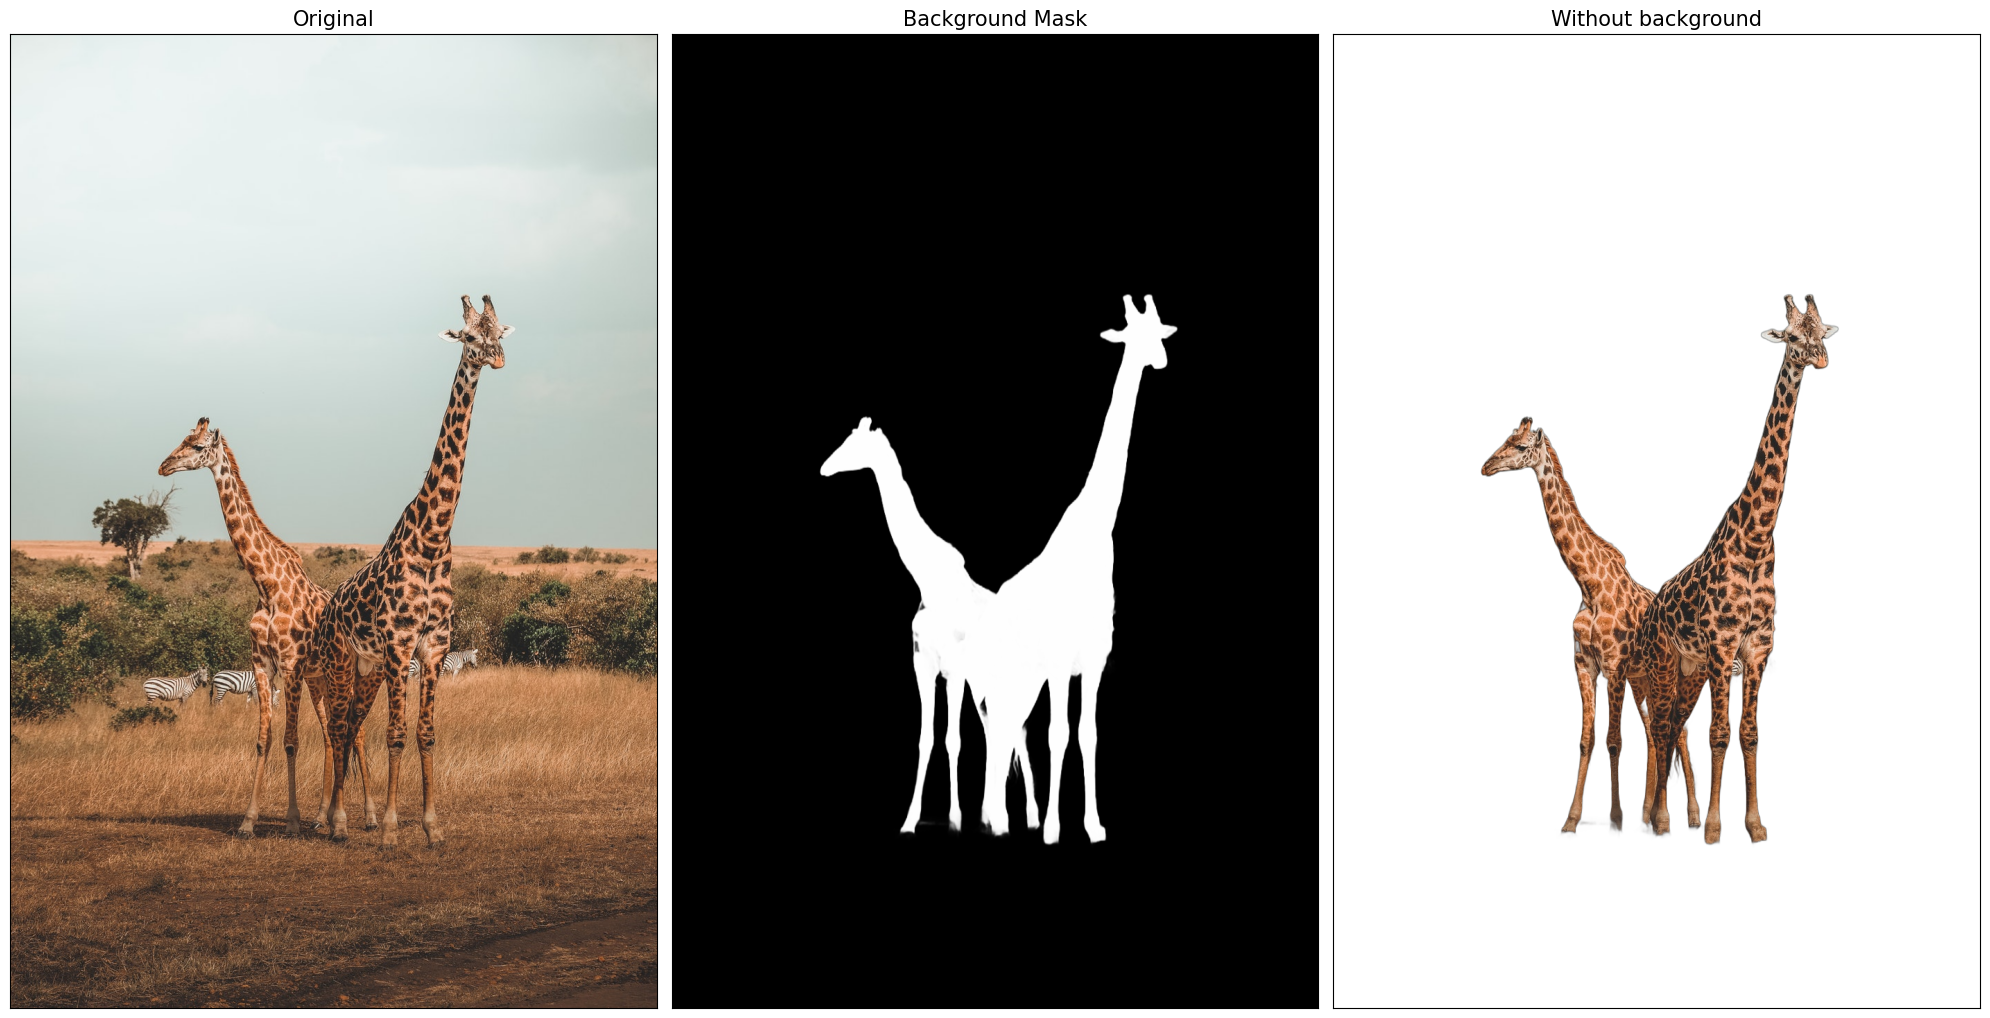

In [7]:
ov_compiled_model = core.compile_model(ov_model_path, device.value)

result = ov_compiled_model(image)[0]

# post process
result_image = postprocess_image(torch.from_numpy(result), orig_im_size)

# save result
pil_im = Image.fromarray(result_image)
no_bg_image = Image.new("RGBA", pil_im.size, (0, 0, 0, 0))
orig_image = Image.open(im_path)
no_bg_image.paste(orig_image, mask=pil_im)
no_bg_image.save("example_image_no_bg.png")

visualize_result(orig_image, pil_im, no_bg_image);

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
def get_background_mask(model, image):
    return model(image)[0]


def on_submit(image):
    original_image = image.copy()

    h, w = image.shape[:2]
    image = preprocess_image(original_image, model_input_size)

    mask = get_background_mask(ov_compiled_model, image)
    result_image = postprocess_image(torch.from_numpy(mask), (h, w))
    pil_im = Image.fromarray(result_image)
    orig_img = Image.fromarray(original_image)
    no_bg_image = Image.new("RGBA", pil_im.size, (0, 0, 0, 0))
    no_bg_image.paste(orig_img, mask=pil_im)

    return no_bg_image

In [ ]:
import requests

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/rmbg-background-removal/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=on_submit)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name='your server name', server_port='server port in int')`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/

In [ ]:
# please uncomment and run this cell for stopping gradio interface
# demo.close()